# **Lab 4: Multi-Layer Perceptron**
**Name(s):** Luke Voinov, Tiffany Nguyen

We use the US Census dataset:

https://www.kaggle.com/muonneutrino/us-census-demographic-data/data

##### **Classification Task:**

The classification task you will be performing is to predict, **for each tract, what the child poverty rate will be**. You will need to convert this from regression to four levels of classification by quantizing the variable of interest.

In [29]:
# Import any dependencies

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### **1. Load, Split, and Balance**

*1.1. Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric.*

In [30]:
path = "C:/Users/lukev/Downloads/archive/acs2017_census_tract_data.csv"
df = pd.read_csv(path)

df.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapErr   73256 non-null  float6

*1.2 Remove any observations that having missing data.*

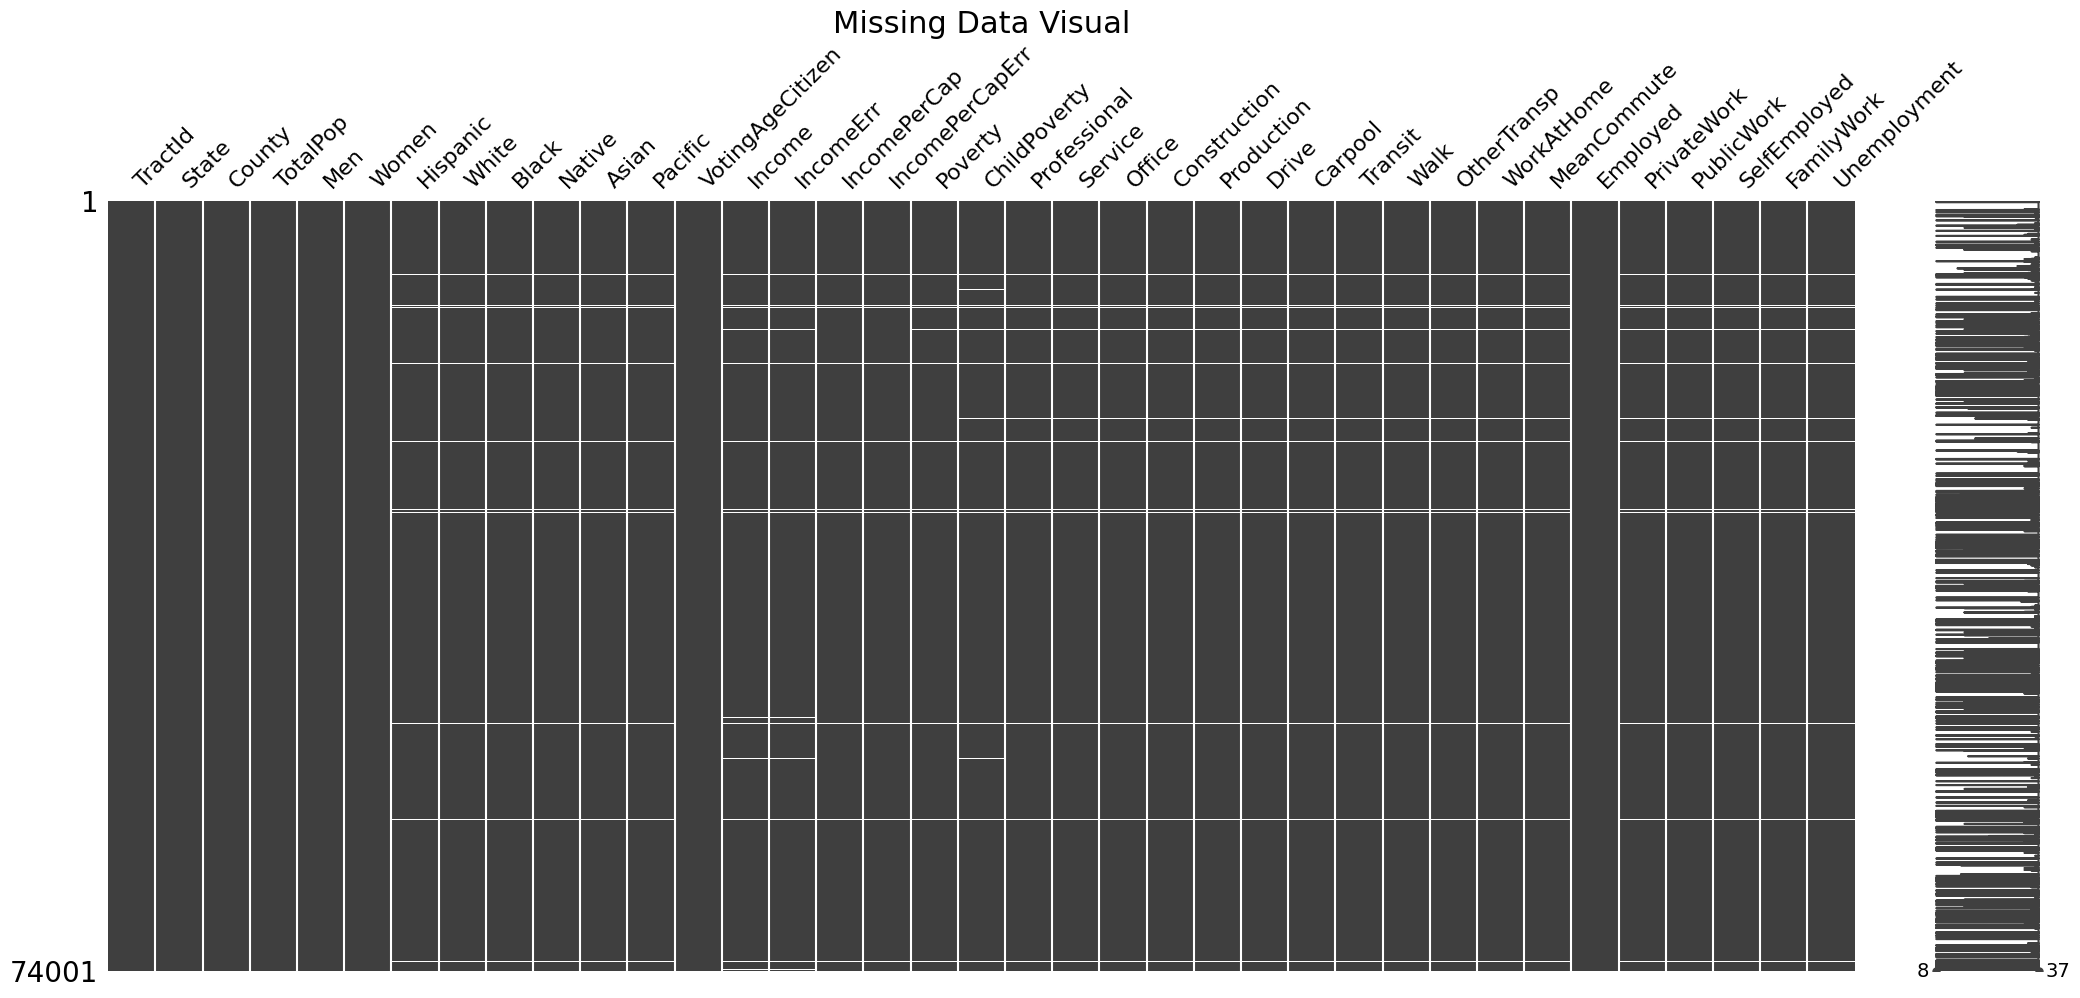

In [32]:
"""
Visualize missing data
"""

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

# External package: conda install missingno 
import missingno as mn

mn.matrix(df)
plt.title("Missing Data Visual",fontsize=22)
plt.show()

In [33]:
print(df.isnull().sum())  # Shows the count of missing values per column

TractId                0
State                  0
County                 0
TotalPop               0
Men                    0
Women                  0
Hispanic             696
White                696
Black                696
Native               696
Asian                696
Pacific              696
VotingAgeCitizen       0
Income              1116
IncomeErr           1116
IncomePerCap         745
IncomePerCapErr      745
Poverty              842
ChildPoverty        1110
Professional         811
Service              811
Office               811
Construction         811
Production           811
Drive                801
Carpool              801
Transit              801
Walk                 801
OtherTransp          801
WorkAtHome           801
MeanCommute          946
Employed               0
PrivateWork          811
PublicWork           811
SelfEmployed         811
FamilyWork           811
Unemployment         810
dtype: int64


We can see that no column is missing too much data. Therefore, it is okay to leave these missing values as they are; imputation is not necessary.

In [34]:
"""
Remove all rows that have a population of less than 100 people.
Delete any rows that contain missing data
"""
# keep rows with TotalPop >= 100, reset index
df_mod = df[df['TotalPop'] >= 100].reset_index(drop=True)

# also delete any row that has any missing value
df_clean = df_mod.dropna().reset_index(drop=True)

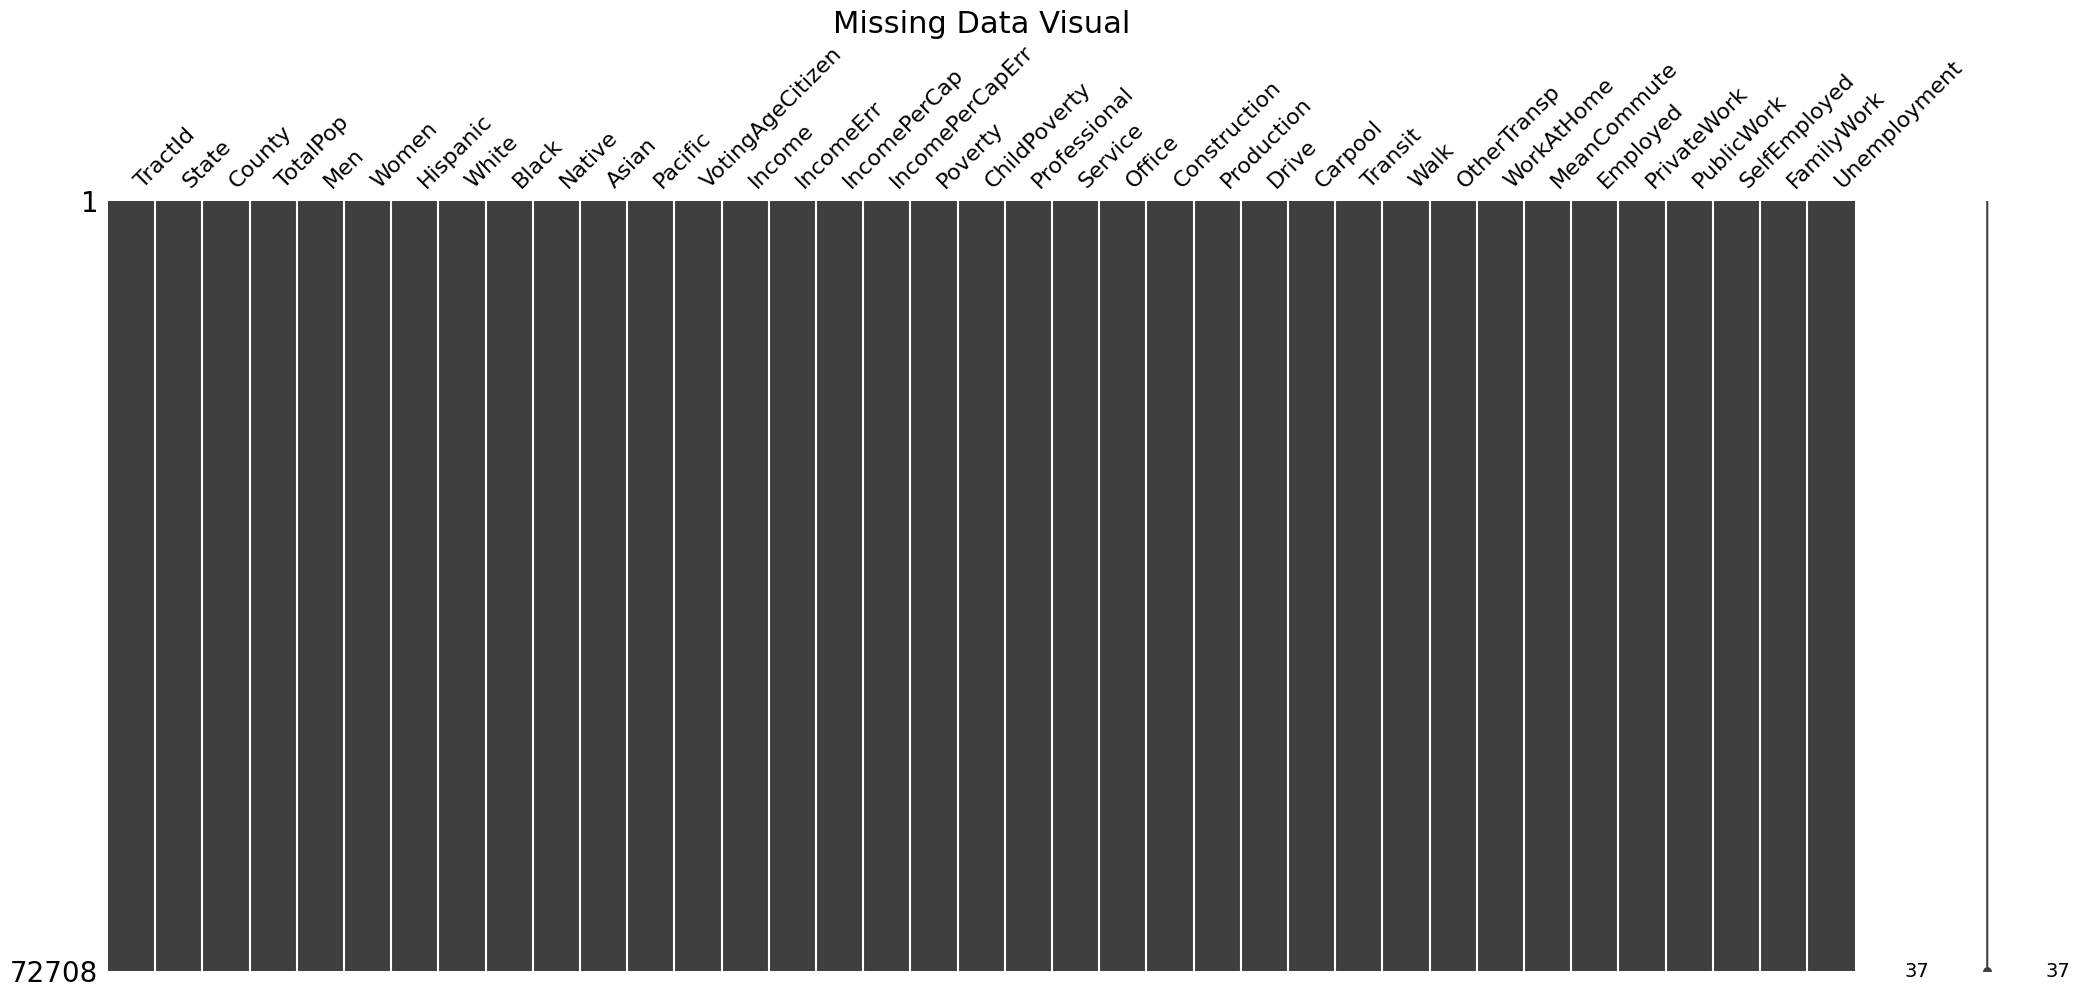

TractId     72708
State       72708
County      72708
TotalPop    72708
Men         72708
dtype: int64

In [35]:
"""
Visualize missing data
"""

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

# External package: conda install missingno 
import missingno as mn

mn.matrix(df_clean)
plt.title("Missing Data Visual",fontsize=22)
plt.show()


df_clean.count().head()

We started with 74001 and ended with 72708 people. This means that deleting every row with a missing value deleted ~2% of the data. This is small and permits deletion.

*1.3 Encode any string data as integers for now.*

We have already seen that there are only two columns that contain strings: the state and the county

In [36]:
# encode states
states = df_clean['State'].unique()
count = 0

df_state_enc = df_clean
for s in states:
    df_state_enc = df_state_enc.replace(s,count)
    count += 1

print("States encoded to ints:\n", df_state_enc['State'].unique())

# encode counties
counties = df_clean['County'].unique()
count = 0

df_enc = df_state_enc
for c in counties:
    df_enc = df_enc.replace(c,count)
    count += 1

print("Counties encoded to ints:\n", df_enc['County'].unique())


C:\Users\lukev\AppData\Local\Temp\ipykernel_24776\2986858223.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_state_enc = df_state_enc.replace(s,count)


States encoded to ints:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]
Counties encoded to ints:
 [   0    1    2 ... 1950 1951 1952]


C:\Users\lukev\AppData\Local\Temp\ipykernel_24776\2986858223.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_enc = df_enc.replace(c,count)


In [37]:
print(df_enc.info(verbose=False)) # Notice the dtypes
df_enc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72708 entries, 0 to 72707
Columns: 37 entries, TractId to Unemployment
dtypes: float64(29), int64(8)
memory usage: 20.5 MB
None


,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,0,0,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,0,0,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,0,0,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,0,0,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,0,0,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


1.4 You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable. 

We decided to keep 'county' because we suspect each county will meaningfully inform child poverty rates.

In [38]:
# see how many instances there are for each county
counties = df_enc['County'].unique()
count = 0
num_each_instance = []

for c in counties:
    bools = df_enc['County'] == c
    num_each_instance.append(df_enc.where(bools == True)['County'].count())


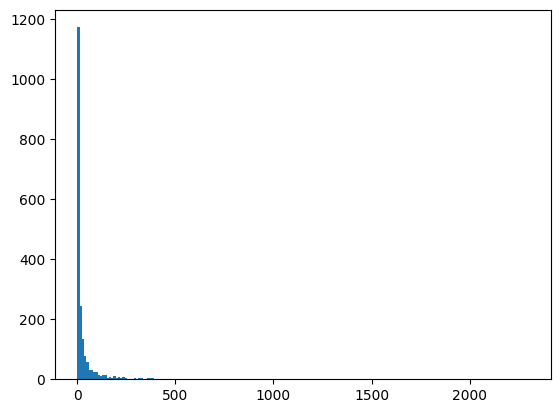

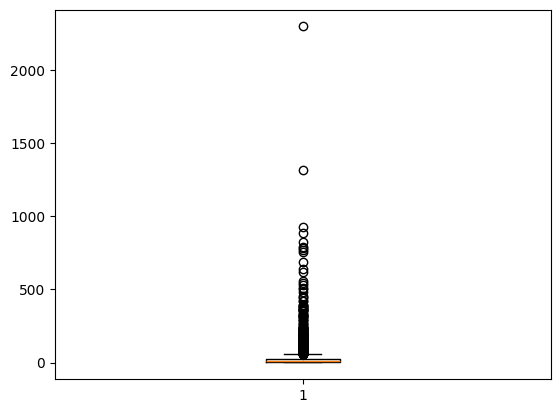

Mean: 37.247950819672134
Median: 9.0


In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(num_each_instance,bins=200)
plt.show()

plt.figure()
plt.boxplot(num_each_instance)
plt.show()

print("Mean:", np.mean(num_each_instance))
print("Median:", np.median(num_each_instance))

Here, as we can see from the graphs, a median is a more representative value due to the tremendous effect of outliers. This median shows that each county has around 9 census tracts, and each census tract has around 1k people. While all the counties are in the same state with the same laws and policies, they can still vary dramatically between each other. As an anecdote, it would be reasonable to suspect that child poverty rates are lower in the Highland Park county as compared to the Oak Cliff county. 

We conclude our decision with a PCA analysis that demonstrate how important of a feature counties are: **CAN I DO THIS**?

The next two requirements will need to be completed together as they might depend on one another. 

*Note: You will need to one hot encode the target, but **do not** one hot encode the categorical data **until** instructed to do so in the lab.*

1.5 Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. *Should balancing of the dataset be done for both the training and testing set? Explain.*

We balanced the dataset according to 4 percentiles: 75% > in poverty level = impoverished, 75 - 50 % are poor, 50 - 25 % are well-off, 25 % < are rich. All of these results will be relative to the training data and will equally split 1/4 of the dataset into each class.

The training dataset must be balanced because it will allow us to categorize among the 4 classes. The test dataset should also be balanced to reflect the real-world use case. If it's unbalanced, then a split test case may result in 99% impoverished instances and 1% of the rest, which is inapproprite if we want to test real-life scenarios.





In [40]:
# This code is adapted from github Copilot. 
# It will split the dataset into 4 quartiles and place 25% of the dataset into a quartile for each quartile, thus evenly distributing the data.


q25 = df_enc['ChildPoverty'].quantile(0.25)
q50 = df_enc['ChildPoverty'].quantile(0.50)
q75 = df_enc['ChildPoverty'].quantile(0.75)

# Create balanced classes
def classify_poverty(value):
    if value <= q25:
        return 0  # rich
    elif value <= q50:
        return 1  # well-off
    elif value <= q75:
        return 2  # poor
    else:
        return 3  # impoverished

df_enc['PovertyClass'] = df_enc['ChildPoverty'].apply(classify_poverty)

In [41]:
df_enc['PovertyClass'] 

0        2
1        3
2        2
3        0
4        2
        ..
72703    3
72704    3
72705    3
72706    3
72707    3
Name: PovertyClass, Length: 72708, dtype: int64

1.6 Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing. There is no need to split the data multiple times for this lab.

In [ ]:
# This code is adapted from voinov_lab3

from sklearn.preprocessing import StandardScaler

# Drop irrelevent columns and classes from feature list
X = df_enc.drop(columns=["TractId", "ChildPoverty", "PovertyClass"])
y = df_enc["ChildPoverty"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Previously the quantile included all the data. Now it has to only include 80% of the data. The test quantiles will be the same as the train one to be realistic.
q25 = y_train.quantile(0.25)
q50 = y_train.quantile(0.50)
q75 = y_train.quantile(0.75)

# Now make the classes  
y_train = y_train.apply(classify_poverty).values
y_test = y_test.apply(classify_poverty).values

# Convert to numpy arrays with proper data types. Provided by github copilot to fix type issues
X_train = X_train.astype(np.float32).values
X_test = X_test.astype(np.float32).values

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)


Training set shape: (58166, 35)
Test set shape: (14542, 35)


### **2. Pre-processing and Initial Modeling**

2.1  You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). **It is recommended to use sigmoids throughout the network, but not required** 

2.2 Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the feature data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 

2.3 Now normalize the continuous numeric feature data

2.4 One hot encode the categorical feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  

2.4 Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.

*Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.*

### **3. Modeling**


3.1 Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.
- Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

3.2 Repeat the previous step, adding support for a fourth layer.

3.3 Repeat the previous step, adding support for a fifth layer. 

3.4 Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (choose either RMSProp or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. **Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.**

### **4. Exceptional Work**

Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance compared to other methods.  